In [186]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import zlib

In [187]:
def hash_name(name):
    return format(zlib.crc32(name.encode()), '08x')  # 8桁の16進数として返す

In [188]:
p = Path('../output/tabelog/')
shop_files = list(p.glob('shop_info_page*.csv'))
review_files = list(p.glob('reviews_page*.csv'))

dfs = []
for shop_file in shop_files:
    df = pd.read_csv(shop_file)
    dfs.append(df)
shop_info = pd.concat(dfs, ignore_index=True)

dfs = []
for review_file in review_files:
    df = pd.read_csv(review_file)
    dfs.append(df)
review = pd.concat(dfs, ignore_index=True)

In [189]:
shop_info

,shop_name,score,open_date,reserve_status,lunch_budget,dinner_budget,address,award,holiday,remarks,nearest_station,review_cnt
0,カドヤ食堂 総本店,3.86,2001年11月6日,予約不可,"￥1,000～￥1,999","￥1,000～￥1,999",大阪府 大阪市西区 新町 4-16-13 キャピタル西長堀 1F,食べログ ラーメン OSAKA 百名店 2023 選出店,火曜日 第2第4の水曜日 (祝日関係なく休み),２０１０年６月３０日（水）移転オープン,西長堀駅,2376
1,ラーメン人生JET,3.78,2010年6月18日,予約不可,～￥999,"￥1,000～￥1,999",大阪府 大阪市福島区 福島 7-12-2,食べログ ラーメン OSAKA 百名店 2023 選出店,NaN,・店内にトイレは有りません。トイレは、店を出て左手にあるビルの外階段をのぼった所にあります。...,福島駅,2548
2,人類みな麺類,3.77,2012年4月12日,予約不可,～￥999,～￥999,大阪府 大阪市淀川区 西中島 1-12-15,食べログ ラーメン OSAKA 百名店 2023 選出店,NaN,"Halalまぜそば提供期間11:00〜20:00 毎日10食限定※12/17,22,28提供なし",南方駅,3285
3,燃えよ麺助,3.77,2016年4月23日,予約不可,～￥999,～￥999,大阪府 大阪市福島区 福島 5-12-21,食べログ ラーメン OSAKA 百名店 2023 選出店,NaN,単店の情報としてよく更新されているのはTwitter。instagramは麦と麺助と共通,福島駅,2080
4,麦と麺助,3.77,2018年5月19日,予約不可,～￥999,NaN,大阪府 大阪市北区 豊崎 3-4-12,食べログ ラーメン OSAKA 百名店 2023 選出店,NaN,単店の情報として更新されているのはTwitter。instagramは燃えよ麺助と共通,中津駅（大阪メトロ）,1442
...,...,...,...,...,...,...,...,...,...,...,...,...
195,麺哲 豊中,3.72,2003年10月16日,予約不可,NaN,NaN,大阪府 豊中市 岡上の町 2-2-6,食べログ ラーメン OSAKA 百名店 2023 選出店,月曜日（月曜日が祝日の場合は翌火曜日も休み）,NaN,豊中駅,539
196,NAKAGAWA わず,3.72,2018年6月5日,予約不可,～￥999,～￥999,大阪府 大阪市東淀川区 菅原 6-24-12,食べログ ラーメン OSAKA 百名店 2023 選出店,NaN,NaN,ＪＲ淡路駅,475
197,らぁめん真,3.72,2015年1月25日,予約不可,"￥1,000～￥1,999",NaN,大阪府 茨木市 駅前 1-3-4,食べログ ラーメン OSAKA 百名店 2023 選出店,NaN,きんせい総本家の暖簾を７年守ってきた店主が独立しJR茨木駅前に開業しました。2019年9月3...,茨木駅,472
198,自家製麺 つきよみ,3.72,2020年5月30日,予約不可,～￥999,～￥999,大阪府 大阪市東淀川区 豊新 5-11-4,食べログ ラーメン OSAKA 百名店 2023 選出店,NaN,NaN,上新庄駅,463


In [190]:
review

,shop_name,title,comment,reviewer_name,visit_date,review_cnt,review_score
0,麺や 福はら,地鶏の旨みが大爆発！！！,●●待ち状況●●平日の19時40分ごろに来店しました！待ちはなかったです。●●注文●●注文は...,ぷくちやん,2023/02訪問,4.0,4.5
1,麺や 福はら,特製芳醇鶏そば（塩）,を、いただきました。100名店ハシゴ2軒目でした。そのためあっさり塩を選択しましたが、結構凄...,chunpei,2024/02訪問,1.0,4.5
2,麺や 福はら,たまたま行列なかった,堺を中心に主にランチを食べ歩いております「のろのり」です。元ネタはhttps://amebl...,のろのり1004,2024/01訪問,1.0,3.2
3,麺や 福はら,全部国産素材ラーメン,特製芳醇鶏そば（塩）と卵かけご飯 12時半過ぎに行くと待たずに入れたが、特別メニューがほとん...,KAZUKAZUKA,2024/01訪問,1.0,3.6
4,麺や 福はら,オイリーだけどあっさり上品,大阪に数軒系列店を展開するお店スープは上品で美味しい麺が味気ないというか、上品？すぎ？女性向...,アユムッ,2024/01訪問,1.0,3.3
...,...,...,...,...,...,...,...
117807,麺処 天川,おおさか激おススメ☆生姜香る旬の限定麺！麺処天川@九条 | おおさか遊食探求～これ食うために...,麺処天川（大阪市西区）TVで紹介させて貰って早1年3ヶ月。ずっと夜は18時スタートと思い込み...,尼崎のおおさか,2020/10訪問,3.0,-
117808,麺処 天川,NaN,[ワンタン塩らあめん]大阪市西区に2019年3月にオープンした【麺処 天川】乾物屋やラーメン...,TAR-KUN,2020/10訪問,2.0,3.5
117809,麺処 天川,非常に丁寧に作られている醤油ラーメン 麺処天川さん,土曜日の晩に初めてこちらへ来てみました。18時頃の訪問で先客は２名でした。入口の券売機で「ア...,へっぽこキッカー,2020/10訪問,1.0,3.4
117810,麺処 天川,再訪,「有機白醤油きのこダレと国産7番焙煎全粒麺の洋？なラーメン」相変わらずのﾈ申クオリティーな炊...,くぴぷち,2022/12訪問,4.0,4.0


In [191]:
review.isnull().sum()

shop_name            0
title            54798
comment          21495
reviewer_name       24
visit_date          24
review_cnt          24
review_score        62
dtype: int64

In [192]:
# drop duplicates
before_len = len(review)
review = review.drop_duplicates()
after_len = len(review)
print(f'dropped {before_len - after_len} duplicates')

dropped 24000 duplicates


In [193]:
# review_scoreの-を削除
before_len = len(review)
review = review[review['review_score'] != '-'].copy()
after_len = len(review)
print(f'dropped {before_len - after_len} rows with "-" review_score')

dropped 2929 rows with "-" review_score


<Axes: >

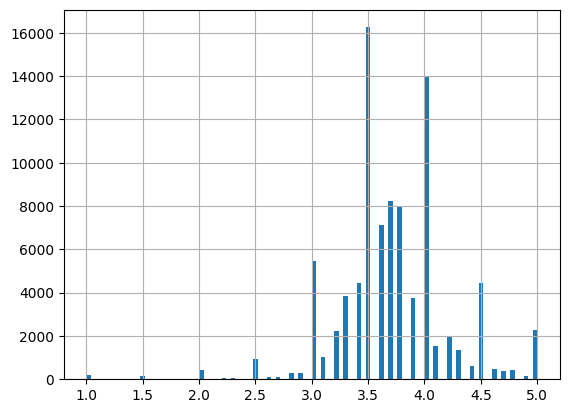

In [194]:
# 数値型に変換
review['review_score'] = review['review_score'].astype(float)
review['review_score'].hist(bins=100)

In [195]:
# commentが空の行を削除
before_len = len(review)
review = review[review['comment'].notnull()].copy()
after_len = len(review)
print(f'dropped {before_len - after_len} rows with null comment')

dropped 16467 rows with null comment


In [196]:
review['visit_date'].unique()

array(['2023/02訪問', '2024/02訪問', '2024/01訪問', '2023/12訪問', '2023/11訪問',
       '2023/10訪問', '2023/09訪問', '2023/08訪問', '2023/07訪問', '2023/06訪問',
       '2023/05訪問', '2023/04訪問', '2023/03訪問', '2023/01訪問', '2022/12訪問',
       '2022/11訪問', '2022/10訪問', '2022/09訪問', '2022/08訪問', '2022/07訪問',
       '2022/06訪問', '2022/05訪問', '2022/04訪問', '2022/03訪問', '2022/02訪問',
       '2022/01訪問', '2021/12訪問', '2021/11訪問', '2021/10訪問', '2021/09訪問',
       '2021/08訪問', '2021/07訪問', '2021/05訪問', '2021/04訪問', '2021/03訪問',
       '2021/02訪問', '2021/01訪問', '2020/12訪問', '2020/11訪問', '2020/10訪問',
       '2020/09訪問', '2020/08訪問', '2020/07訪問', '2020/06訪問', '2020/05訪問',
       '2020/04訪問', '2020/03訪問', '2020/02訪問', '2020/01訪問', '2019/12訪問',
       '2019/11訪問', '2019/10訪問', '2019/09訪問', '2019/08訪問', '2019/07訪問',
       '2019/06訪問', '2019/05訪問', '2019/04訪問', '2019/03訪問', '2019/02訪問',
       '2018/12訪問', '2018/11訪問', '2018/09訪問', '2018/08訪問', '2018/07訪問',
       '2018/04訪問', '2018/03訪問', '2018/02訪問', '2018/01訪問', '2017

In [197]:
# visit_dateが正しい書式のものだけ残す
before_len = len(review)
pattern = r'^\d{4}/\d{2}訪問$'
review = review[review['visit_date'].str.match(pattern)].copy()
after_len = len(review)
print(f'dropped {before_len - after_len} rows with invalid visit_date')

dropped 4362 rows with invalid visit_date


In [198]:
# visit_dateから年と月を抽出
review['visit_year'] = review['visit_date'].str[0:4].astype(int)
review['visit_month'] = review['visit_date'].str[5:7].astype(int)

<Axes: >

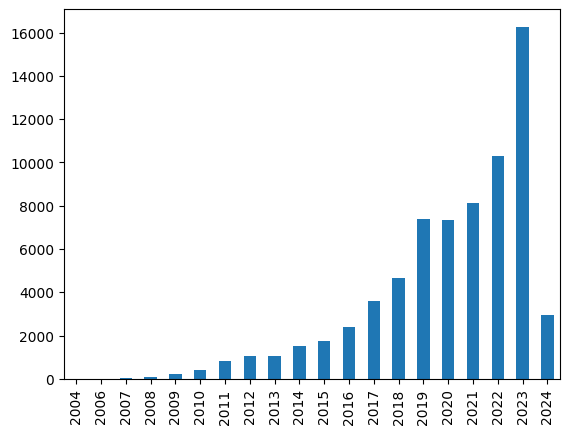

In [199]:
# visit_yearごとの件数を可視化
visit_year_count = review['visit_year'].value_counts().sort_index()
visit_year_count.plot(kind='bar')

In [200]:
# csvを開いたときに列が崩れるのでセミコロン、tabを変換
review['title'] = review['title'].str.replace(';', ' ')
review['comment'] = review['comment'].str.replace(';', ' ')
review['title'] = review['title'].str.replace('\t', ' ')
review['comment'] = review['comment'].str.replace('\t', ' ')
review['reviewer_name'] = review['reviewer_name'].str.replace(';', '')
review['reviewer_name'] = review['reviewer_name'].str.replace('\t', '')

In [201]:
# shop_infoの重複を削除
before_len = len(shop_info)
shop_info = shop_info.drop_duplicates(subset='shop_name')
after_len = len(shop_info)
print(f'dropped {before_len - after_len} duplicates')

dropped 3 duplicates


In [202]:
# 匿名化
shop_info['shop_id'] = shop_info['shop_name'].apply(hash_name)
review['shop_id'] = review['shop_name'].apply(hash_name)
review['reviewer_id'] = review['reviewer_name'].apply(hash_name)

/tmp/ipykernel_825875/2240105841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop_info['shop_id'] = shop_info['shop_name'].apply(hash_name)


In [203]:
review = review.sort_values(['reviewer_name', 'visit_year', 'visit_month'], ascending=True)

In [204]:
review.to_csv('../output/tabelog/review_cleaned.csv', index=False)

In [205]:
shop_info.to_csv('../output/tabelog/shop_info_cleaned.csv', index=False)

In [206]:
review.reviewer_id.str.len()

61995     8
88377     8
38801     8
95040     8
89897     8
         ..
69977     8
60553     8
13984     8
47200     8
103614    8
Name: reviewer_id, Length: 70054, dtype: int64

In [209]:
print(shop_info.shop_name.nunique(), shop_info.shop_id.nunique()) 
print(review.reviewer_name.nunique(), review.reviewer_id.nunique()) 

197 197
15858 15858


In [211]:
review.sort_values('shop_name')

,shop_name,title,comment,reviewer_name,visit_date,review_cnt,review_score,visit_year,visit_month,shop_id,reviewer_id
40474,KUCHE,NaN,濃厚つけ麺。旨し。,0f8147,2021/09訪問,1.0,4.0,2021,9,5918225e,b06b2df2
40279,KUCHE,大阪東淀川区の人気店で焦がし醤油つけ麺！,まったり濃厚つけ汁にぷりぷりの太麺がグー(^^) 大阪東淀川区の人気ラ...,ro.yamanaka,2023/06訪問,1.0,3.7,2023,6,5918225e,07a01104
40253,KUCHE,ラーメンのKUROも看板メニューつけ麺KUROに引けを取らない衝撃の美味さ！！,はいはーい、ラーメンの時間ですよ〜ラーメン百名店OSAKA2023〜《KUCHE 》『らー麺...,ramentimesだいち,2023/12訪問,4.0,4.0,2023,12,5918225e,2e410206
40617,KUCHE,創作系ラーメン,クーシェってよみます！上新庄かな？あのあたりあまり行かないからわからない！北大阪に住んでるの...,リック ソルソル,2016/05訪問,1.0,3.5,2016,5,5918225e,b3adf72e
40323,KUCHE,NaN,つけ麺 KURO青波に続いて二件目。こちらのお店も4年ぶりかな。 初めて食べた時のインパクト...,s.shun,2022/09訪問,1.0,3.3,2022,9,5918225e,85891baf
...,...,...,...,...,...,...,...,...,...,...,...
31898,麺麓menroku,鴨出汁そばはかなりあっさりしています。 鴨白湯そばは濃厚で美味しいです。 鴨ロースのチャ...,鴨出汁そばはかなりあっさりしています。鴨白湯そばは濃厚で美味しいです。鴨ロースのチャーシュー...,443bmt,2016/10訪問,1.0,3.0,2016,10,02b6523e,547e1290
31636,麺麓menroku,お洒落つけ麺！まるでフレンチ♪,時々やってくる美味しいラーメンを食べたい気分の波。今回はつけ麺を食べに行くことにしました。食...,はむりんぷりん,2023/08訪問,1.0,3.5,2023,8,02b6523e,bf7cae92
32166,麺麓menroku,鴨肉旨い❗️京都まで行かなくてもここで喰らえるよ❗️,『麺麓menroku』（メンロク）枚方市大峰元町『鴨白湯そば』トッピングで「紀州鴨チャーシュ...,okada847,2018/05訪問,1.0,3.4,2018,5,02b6523e,e0370aa5
31872,麺麓menroku,NaN,(σ⁎˃ᴗ˂⁎)σண♡*旨い！嬉しい～.｡.:*♡✿ฺ,nico-anton,2018/11訪問,9.0,4.0,2018,11,02b6523e,20f0c380
